In [1]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [2]:
if len(tf.config.list_physical_devices('GPU')):
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Loading data

In [3]:
from data_getter import *

30220 summaries containing 'No summary available'
6142 summaries containing 'Full story available on'
Duplicate summaries removed: 14242
Duplicate headlines removed: 404
randomizing order of data


In [4]:
balanced_dataset

,datetime,headline,summary,related,lang,source,1stepChange,2stepChange,3stepChange,priceChangeClass,6stepChange
0,2020-10-21 10:11:13-05:00,Q4 2020 EPS Estimates for Portland General Ele...,Portland General Electric (NYSE:POR) – KeyCorp...,POR,en,Transcript Daily,1.004938,1.008186,1.007406,1,1.015333
1,2019-09-27 02:31:11-05:00,Tata Motors tumbles 4 per cent on reports of J...,The stock tumbled over 4 per cent to Rs 119.30...,TTM,en,The Economic Times India,0.986127,0.986127,0.995376,0,0.996532
2,2020-01-23 05:20:00-05:00,Billionaire businessman Leslie Wexner refuses ...,"Leslie Wexner is the CEO of L Brands, which in...",LB,en,ABC News,1.002445,1.007335,1.015159,1,1.019560
3,2020-07-03 06:56:15-05:00,Boeing communications boss Niel Golightly resi...,Boeing communications boss Niel Golightly has ...,BA,en,New York Post,1.029266,1.020872,1.020707,2,1.025787
4,2020-11-19 09:15:00-05:00,Condor Hospitality Announces Modification to I...,"NORFOLK, Neb.--(BUSINESS WIRE)---- $CDOR #Hote...",BMO,en,Business Wire,1.008436,1.003431,1.004289,1,1.001859
...,...,...,...,...,...,...,...,...,...,...,...
98695,2020-06-12 10:00:31-05:00,BAE to produce more Vertical Launching System ...,BAE Systems will produce multiple types of Ver...,BA,en,UK Defence Journal,0.986078,0.947778,0.954360,0,0.978162
98696,2019-12-05 08:00:00-05:00,TE's new thermal bridge solution significantly...,"HARRISBURG, Pa., Dec. 5, 2019 /PRNewswire/ -- ...",TEL,en,PR Newswire,1.010157,1.006809,1.006586,2,1.009934
98697,2020-03-19 08:45:00-05:00,"Coronavirus Rampage Continues For Skechers, Gu...",Skechers (SKX) shuts company-owned retail stor...,SKX,en,Zacks Investment Research,0.920465,0.922326,0.980465,0,0.989191
98698,2020-04-09 15:16:00-05:00,Southwestern Energy Schedules First Quarter Co...,"SPRING, Texas--(BUSINESS WIRE)--SOUTHWESTERN E...",SWN,en,Business Wire,1.020747,1.039419,1.008299,2,1.045643


## Loading bert model and preprocessor

In [5]:
small_bert_url = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
small_bert_preprocessor = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2"


#TODO: fix sequence length?
seq_length=512
bert_preprocess_model = hub.KerasLayer(small_bert_preprocessor)
bert_preprocess = hub.load(small_bert_preprocessor)
bert_model = hub.KerasLayer(small_bert_url)

In [6]:
tt = "Indian shares fell on Wednesday after the International Monetary Fund cut its economic growth forecast for the country for the second time in nearly four months, while Wipro's quarterly profit miss also weighed on sentiment."
tok = bert_preprocess.tokenize(tf.constant([tt]))
text_preprocessed = bert_preprocess.bert_pack_inputs([tok], tf.constant(seq_length))

print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)


Shape Word Ids :  (1, 512)
Shape Mask     :  (1, 512)
Shape Type Ids :  (1, 512)


# Own code

In [7]:
preprocessor = hub.load(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2")

# Step 1: tokenize batches of text inputs.
text_inputs = [tf.keras.layers.Input(shape=(), dtype=tf.string)
               ] # This SavedModel accepts up to 2 text inputs.
tokenize = hub.KerasLayer(preprocessor.tokenize)
tokenized_inputs = [tokenize(segment) for segment in text_inputs]

# Step 3: pack input sequences for the Transformer encoder.
seq_length = 128  # Your choice here.
bert_pack_inputs = hub.KerasLayer(
    preprocessor.bert_pack_inputs,
    arguments=dict(seq_length=seq_length))  # Optional argument.
encoder_inputs = bert_pack_inputs(tokenized_inputs)

### Preprocess some text

In [8]:
test_text = ["ValuEngine upgraded shares of Skechers USA (NYSE:SKX) from a hold rating to a buy rating in a research note issued to investors on SaturdayValuEngine upgraded shares of Skechers USA (NYSE:SKX) from a hold rating to a buy rating in a research note issued to investors on SaturdayValuEngine upgraded shares of Skechers USA (NYSE:SKX) from a hold rating to a buy rating in a research note issued to investors on SaturdayValuEngine upgraded shares of Skechers USA (NYSE:SKX) from a hold rating to a buy rating in a research note issued to investors on SaturdayValuEngine upgraded shares of Skechers USA (NYSE:SKX) from a hold rating to a buy rating in a research note issued to investors on SaturdayValuEngine upgraded shares of Skechers USA (NYSE:SKX) from a hold rating to a buy rating in a research note issued to investors on SaturdayValuEngine upgraded shares of Skechers USA (NYSE:SKX) from a hold rating to a buy rating in a research note issued to investors on Saturday morning, ValuEngine reports. SKX has been the topic of several other reports. 140166 increased their price objective on Skechers USA from $32.00 to $39.00 in a research report on Friday, July"]

text_preprocessed = bert_preprocess_model(test_text)
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"]}')
print(f'Input Mask : {text_preprocessed["input_mask"]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"]}')
len(test_text[0].split())

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [[  101  3643  3070  3170  9725  6661  1997 15315 27635  2869  3915  1006
   6396  3366  1024 15315  2595  1007  2013  1037  2907  5790  2000  1037
   4965  5790  1999  1037  2470  3602  3843  2000  9387  2006  5095 10175
  24997 11528  2063  9725  6661  1997 15315 27635  2869  3915  1006  6396
   3366  1024 15315  2595  1007  2013  1037  2907  5790  2000  1037  4965
   5790  1999  1037  2470  3602  3843  2000  9387  2006  5095 10175 24997
  11528  2063  9725  6661  1997 15315 27635  2869  3915  1006  6396  3366
   1024 15315  2595  1007  2013  1037  2907  5790  2000  1037  4965  5790
   1999  1037  2470  3602  3843  2000  9387  2006  5095 10175 24997 11528
   2063  9725  6661  1997 15315 27635  2869  3915  1006  6396  3366  1024
  15315  2595  1007  2013  1037  2907  5790   102]]
Input Mask : [[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 

193

In [9]:
bert_results = bert_model(text_preprocessed)

print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.9872788   0.6081531   0.24679302 -0.06692457  0.10544986  0.8710267
  0.9948231  -0.9355519  -0.6580255  -0.833649   -0.17882733  0.80779314]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.31549835 -0.11632712  0.46051133 ... -1.6071644   0.23618475
  -0.16490716]
 [-0.3047495  -0.9911476   0.08962081 ... -0.61106586  1.365704
   0.05055675]
 [-0.45908156  0.74033844 -0.00935665 ... -0.8183393   0.20104626
  -0.29675996]
 ...
 [-0.9397467   1.5017155   0.36378935 ... -0.8516258   0.58350456
   0.8833866 ]
 [-0.04212323  0.2719484   0.11452954 ... -0.38150007  0.55415344
   0.4019239 ]
 [ 0.10870774 -0.4503712  -0.7897196  ... -0.6657064  -0.32420114
   0.7618558 ]]


In [37]:
def create_classifier_model():
    text_input_layer = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
    preprocessing_layer = hub.KerasLayer(small_bert_preprocessor, name="preprocessor")
    encoded_input = preprocessing_layer(text_input_layer)
    encoder = hub.KerasLayer(small_bert_url, trainable=True, name="bert_encoder")
    outputs = encoder(encoded_input)
    net = outputs["pooled_output"]
    #net = tf.keras.layers.Dropout(0.1)(net)
    #net= tf.keras.layers.Dense(512, activation="relu", name="layer1")(net)
    #net= tf.keras.layers.Dense(256, activation="relu", name="layer2")(net)
    #net= tf.keras.layers.LSTM(64, name="lstm")(net)
    #net= tf.keras.layers.Dense(128, activation="relu", name="layer3")(net)
    #net= tf.keras.layers.Dense(64, activation="relu", name="layer4")(net)
    net = tf.keras.layers.Dense(3, activation='softmax', name="classifier")(net)
    return tf.keras.Model(text_input_layer, net)

In [38]:
classifier_model = create_classifier_model()
bert_raw_result = classifier_model(tf.constant(test_text))
print(bert_raw_result)
#print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.08090143 0.03038691 0.88871163]], shape=(1, 3), dtype=float32)


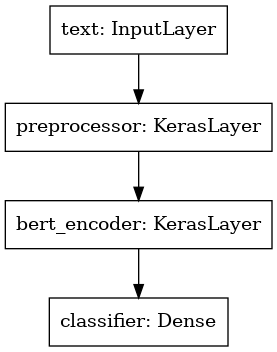

In [39]:
tf.keras.utils.plot_model(classifier_model)

In [40]:
epochs = 1
steps_per_epoch = len(train_data.index)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5 # 1e-4
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [41]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
classifier_model.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=metric)

In [42]:
x_train = np.array(train_data.summary)
y_train = np.array(train_data.priceChangeClass).astype(np.int8)

#x_train = x_train[:50000]
#y_train = y_train[:50000]

#x_train
history = classifier_model.fit(x_train, 
                                y_train, 
                                batch_size=8,
                                validation_data=(val_x, val_y),
                                epochs=5)
#y_train

Epoch 1/5
8883/8883 [==============================] - 833s 94ms/step - loss: 1.0890 - accuracy: 0.3806 - val_loss: 1.0791 - val_accuracy: 0.3967
Epoch 2/5
8883/8883 [==============================] - 865s 97ms/step - loss: 1.0595 - accuracy: 0.4353 - val_loss: 1.0599 - val_accuracy: 0.4311
Epoch 3/5
8883/8883 [==============================] - 845s 95ms/step - loss: 1.0209 - accuracy: 0.4930 - val_loss: 1.0653 - val_accuracy: 0.4436
Epoch 4/5
8883/8883 [==============================] - 854s 96ms/step - loss: 0.9741 - accuracy: 0.5540 - val_loss: 1.0738 - val_accuracy: 0.4450
Epoch 5/5
8883/8883 [==============================] - 852s 96ms/step - loss: 0.9295 - accuracy: 0.6053 - val_loss: 1.0782 - val_accuracy: 0.4457


In [65]:
history = classifier_model.fit(x_train, 
                                y_train, 
                                batch_size=8,
                                validation_data=(val_x, val_y),
                                epochs=1)

8883/8883 [==============================] - 846s 95ms/step - loss: 0.8900 - accuracy: 0.6502 - val_loss: 1.0844 - val_accuracy: 0.4418


In [53]:

test_x = np.array(test_data.summary)
test_y = np.array(test_data.priceChangeClass).astype(np.int8)

#res = classifier_model.evaluate(test_x, test_y)
#print("test loss, test acc:", res)


In [54]:
pred = classifier_model.predict(test_x)

In [55]:
pred

array([[9.9536949e-01, 1.2367263e-05, 4.6181018e-03],
       [4.3414003e-01, 5.4377719e-04, 5.6531620e-01],
       [8.9267193e-04, 6.8906365e-06, 9.9910045e-01],
       ...,
       [9.9909604e-01, 6.6379025e-06, 8.9729310e-04],
       [3.0814154e-02, 8.9990324e-01, 6.9282591e-02],
       [1.6111651e-01, 7.2737387e-04, 8.3815610e-01]], dtype=float32)

In [56]:
#tf.math.confusion_matrix(labels=test_y, predictions=res)

rez = []
for elem in pred:
    aa = tf.math.argmax(elem)
    rez.append(aa.numpy())

In [57]:
rez = np.array(rez)

In [58]:
np.count_nonzero(rez == test_y) / len(rez)

0.43256782618484746

In [59]:
tf.math.confusion_matrix(labels=test_y, predictions=rez)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[2554, 1146, 2214],
       [1635, 2263, 2019],
       [1973, 1094, 2868]], dtype=int32)>

In [60]:
m = tf.keras.metrics.Accuracy()
m.update_state(rez, test_y)
m.result().numpy()

0.43256783

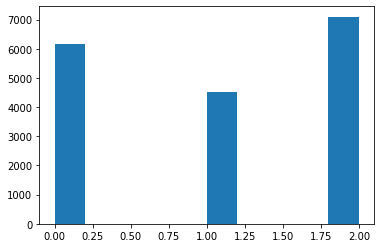

In [61]:
plt.hist(rez)
plt.show()

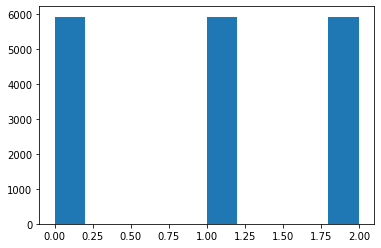

In [62]:
plt.hist(test_y)
plt.show()

In [26]:
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [64]:
from sklearn.metrics import f1_score,classification_report

print(classification_report(test_data.priceChangeClass, rez))

              precision    recall  f1-score   support

           0       0.41      0.43      0.42      5914
           1       0.50      0.38      0.43      5917
           2       0.40      0.48      0.44      5935

    accuracy                           0.43     17766
   macro avg       0.44      0.43      0.43     17766
weighted avg       0.44      0.43      0.43     17766



In [67]:
from data_analyser import calc_rate_of_return
rate_return = calc_rate_of_return(rez, test_data["1stepChange"].tolist(), buy_class=2)
np.mean(rate_return)


1.0031545414459269

In [68]:
np.mean(test_data["1stepChange"].tolist())

1.0001833401770026